# Analysis Education Zones


## Steps

    [*] Get The Data
    [*] Simple Descriptive :
        [*] Overall
        [*] last sync Descriptive
        [*] SD, SMP, SMA Portion
        [] School Numbers
    [*] Mapping :
        [*] Example map with point
        [*] Example Radius
        [*] Example School Number Heatmap
    [] Questions :
        [*] Most Sparse Province in terms of school number
        [] From top 3 cities, Standardized number per cities and do the heatmap
        [] From top 3 cities, which kecamatan which has high number school with low facilities (number of class)
        [] From top cities, what is percentage area coverage for different radius
        [] Bandung Case, what is percentage people coverage for different radius
        [] Bandung Case, what is the school choice for every people?
        [] Voronoi in bandung?
        
<!-- DKI Jakarta, Kota Surabaya, Kota Medan, Kota Bandung, Kota Makassar, Kota Palembang -->
<!-- https://ilmupengetahuanumum.com/10-kota-terbesar-di-indonesia-menurut-jumlah-penduduknya/ -->
<!-- https://ilmugeografi.com/ilmu-sosial/kota-terpadat-di-indonesia -->


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# https://medium.com/tinghaochen/install-geopandas-on-macos-mojave-32c0ab0b7d18
import geopandas as gpd
from geopandas import GeoSeries
import fiona
from shapely.geometry import LineString, Polygon, Point
import numpy as np
import shapely
import descartes
import Levenshtein
# import geog
import shapely.geometry
import geoplot
import matplotlib
import pyproj
from shapely.ops import transform
from functools import partial


from ipywidgets import *
from IPython.display import display, HTML
import ipywidgets as widgets

In [2]:
PATH_PROCESSED='../data/processed/'
PATH_INTERIM='../data/interim/'
PATH_MODEL="../models/"

## Get Data

In [3]:
data_skul=pd.read_csv(PATH_PROCESSED+'20190901_all_sekolah_genap2019_data_latlong.csv')
map_reference=pd.read_csv(PATH_INTERIM+'reference_our_data_to_map_used.csv')
map_reference.columns=['kab_kota','NAME_2','Lev_Ratio','Inter_Ratio','Rank','Rank2']

In [4]:
data_skul.head()

,provinsi,kab_kota,kecamatan,nama_sekolah,npsn,bp,status,last_sync,jml_sync,pd,rombel,guru,pegawai,ruang_kelas,ruang_lab,ruang_perpus,url_sekolah,coordinate,lintang,bujur
0,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD N SEUNEUBOK TEUNGOH,10107900,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3594000,Bujur : 95.9281000",4.3594,95.9281
1,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE BATEE,10110676,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3453000,Bujur : 95.9736000",4.3453,95.9736
2,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE SUNDAK,10110270,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3257000,Bujur : 95.9761000",4.3257,95.9761
3,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ARONGAN WOYLA,10107859,SD,Negeri,-,0,0.0,0,0,0,6,0,0,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.2994000,Bujur : 95.9536000",4.2994,95.9536
4,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI COT BULOH,10107863,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3252000,Bujur : 95.9576000",4.3252,95.9576


In [5]:
data_skul['is_updated']=(data_skul.last_sync!='-').astype(int)

In [6]:
data_skul.sample(10)

,provinsi,kab_kota,kecamatan,nama_sekolah,npsn,bp,status,last_sync,jml_sync,pd,...,guru,pegawai,ruang_kelas,ruang_lab,ruang_perpus,url_sekolah,coordinate,lintang,bujur,is_updated
123347,Prov. Jawa Tengah,Kab. Purbalingga,Kec. Padamara,SD N 1 PADAMARA,20303515,SD,Negeri,-,0,0.0,...,0,0,10,1,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -7.3814350,Bujur : 109.3182120",-7.381435,109.318212,0
83141,Prov. Banten,Kab. Lebak,Kec. Cihara,SDN 1 BARUNAI,20602607,SD,Negeri,-,0,0.0,...,0,0,6,1,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -6.8426000,Bujur : 106.1143000",-6.842600,106.114300,0
138740,Prov. D.I. Yogyakarta,Kota Yogyakarta,Kec. Jetis,SMKN 2 YOGYAKARTA,20403280,SMK,Negeri,-,0,0.0,...,0,0,50,12,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -7.7778000,Bujur : 110.3676000",-7.777800,110.367600,0
89062,Prov. Sulawesi Selatan,Kab. Luwu Timur,Kec. Tomoni,SD NEGERI NO. 189 UJUNG BARU,40309902,SD,Negeri,22 Aug 2019 13:05:30,1,94.0,...,9,2,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -2.4472000,Bujur : 120.6209000",-2.447200,120.620900,1
163620,Prov. D.I. Yogyakarta,Kab. Sleman,Kec. Ngaglik,SD NEGERI TARAMAN,20400805,SD,Negeri,-,0,0.0,...,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -7.7187000,Bujur : 110.4178000",-7.718700,110.417800,0
95555,Prov. Jawa Timur,Kab. Malang,Kec. Kepanjen,SMAS ISLAM KEPANJEN,20517837,SMA,Swasta,22 Aug 2019 18:30:11,6,365.0,...,33,9,16,3,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -8.1330000,Bujur : 112.5817000",-8.133000,112.581700,1
6757,Prov. Bengkulu,Kab. Bengkulu Utara,Kec. Air Besi,SMPN 37 BENGKULU UTARA,10703520,SMP,Negeri,21 Aug 2019 21:22:27,1,28.0,...,11,2,3,1,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -3.5291000,Bujur : 102.1927000",-3.529100,102.192700,1
161620,Prov. Jawa Timur,Kab. Pamekasan,Kec. Pegantenan,SMP BUSTANUL ULUM,20537402,SMP,Swasta,-,0,0.0,...,0,0,3,1,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -7.0876000,Bujur : 113.4938000",-7.087600,113.493800,0
15869,Prov. Jawa Timur,Kab. Bondowoso,Kec. Klabang,UPTD SPF SMP Negeri 1 Klabang,20521810,SMP,Negeri,-,0,0.0,...,0,0,12,1,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -7.8431000,Bujur : 113.9456000",-7.843100,113.945600,0
44676,Prov. Riau,Kab. Indragiri Hulu,Kec. Kelayang,SD NEGERI 020 MUARA DANAU,10494269,SD,Negeri,-,0,0.0,...,0,0,5,0,0,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -.7280000,Bujur : 102.1102000",-0.728000,102.110200,0


In [7]:
map_reference.head()

,kab_kota,NAME_2,Lev_Ratio,Inter_Ratio,Rank,Rank2
0,Kab. Aceh Barat,Aceh Barat,0.800000,1.000000,1.0,1.0
1,Kab. Aceh Barat Daya,Aceh Barat Daya,0.857143,1.000000,1.0,1.0
2,Kab. Aceh Besar,Aceh Besar,0.800000,1.000000,1.0,1.0
3,Kab. Aceh Jaya,Aceh Jaya,0.782609,0.989796,1.0,1.0
4,Kab. Aceh Selatan,Aceh Selatan,0.827586,0.995098,1.0,1.0


In [8]:
fp = PATH_MODEL+'gadm36_IDN_shp/gadm36_IDN_2.shp'
map_df = gpd.read_file(fp)

## Simple Descriptive 

#### 1. Overall

In [9]:
# overall
data_skul.shape

(218135, 21)

In [10]:
len(data_skul.provinsi.unique())

34

In [11]:
len(data_skul.kecamatan.unique())

6683

#### 2. last sync Descriptive

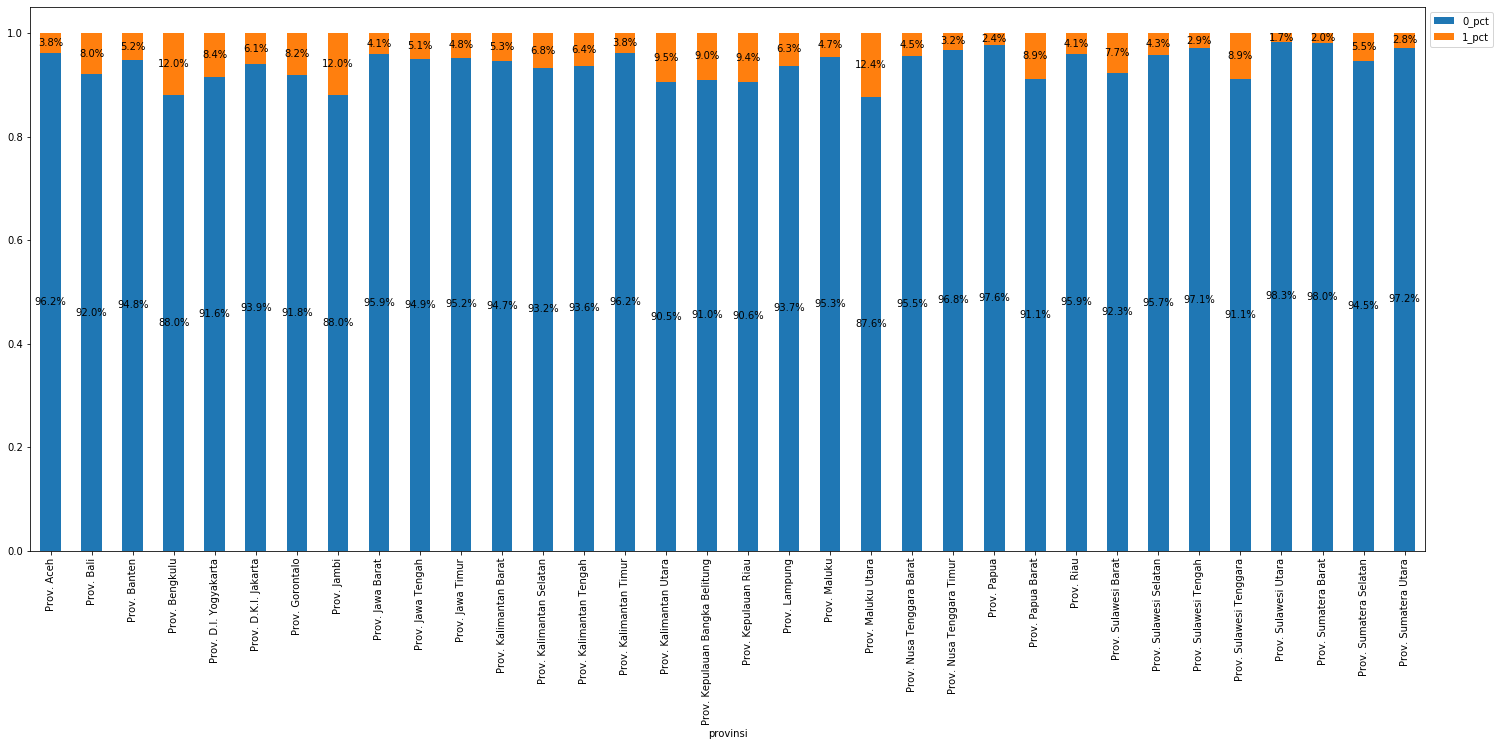

In [12]:
data_update_skul=data_skul.groupby(['provinsi','is_updated']).size().unstack()
data_update_skul['0_pct']=data_update_skul[0]/data_update_skul.sum(axis=1)
data_update_skul['1_pct']=data_update_skul[1]/data_update_skul.sum(axis=1)
ax=data_update_skul[['0_pct','1_pct']].plot(kind='bar', stacked=True, figsize=(25,10))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.legend(bbox_to_anchor=(1, 1))


/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


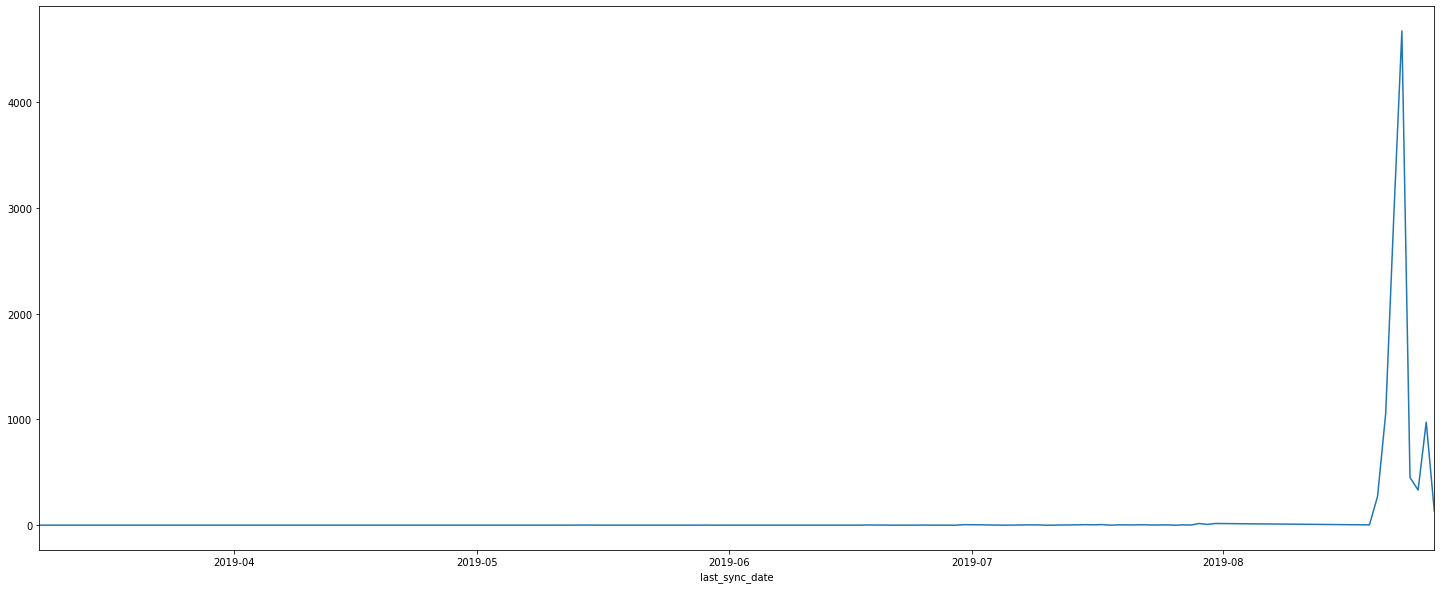

In [13]:
df_updated_skul=data_skul[data_skul.is_updated==1]
df_updated_skul['last_sync']=pd.to_datetime(df_updated_skul['last_sync'])
df_updated_skul['last_sync_date']=df_updated_skul.last_sync.apply(lambda x: x.date())
df_updated_skul.groupby('last_sync_date').size().plot(figsize=(25,10))

#### 3. SD, SMP, SMA Portion

In [14]:
count_bp=data_skul.groupby('bp').size()
pd.DataFrame({'skul_count':count_bp,'skul_pct':count_bp/count_bp.sum()}).sort_values('skul_count',ascending=False)

,skul_count,skul_pct
bp,,
SD,148310,0.679900
SMP,39482,0.180998
SMK,14049,0.064405
SMA,13606,0.062374
SLB,1902,0.008719
SPK SD,197,0.000903
SPK SMP,171,0.000784
SDLB,147,0.000674
SPK SMA,118,0.000541


In [15]:
count_bp=data_skul.groupby(['bp','status']).size()
pd.DataFrame({'skul_count':count_bp,'skul_pct':count_bp/count_bp.sum()})

skul_count  skul_pct
bp      status                      
SD      Negeri      131267  0.601770
        Swasta       17043  0.078131
SDLB    Negeri          43  0.000197
        Swasta         104  0.000477
SLB     Negeri         513  0.002352
        Swasta        1389  0.006368
SMA     Negeri        6750  0.030944
        Swasta        6856  0.031430
SMK     Negeri        3537  0.016215
        Swasta       10512  0.048190
SMLB    Negeri           8  0.000037
        Swasta          57  0.000261
SMP     Negeri       23089  0.105847
        Swasta       16393  0.075151
SMPLB   Negeri           8  0.000037
        Swasta          80  0.000367
SPK SD  Swasta         197  0.000903
SPK SMA Negeri           1  0.000005
        Swasta         117  0.000536
SPK SMP Negeri           1  0.000005
        Swasta         170  0.000779

In [16]:
dprov_cnt_all=[]
for prov in data_skul.provinsi.unique():
    dprov=data_skul[(data_skul.provinsi==prov)&(data_skul.bp!='SD')]
    dprov_cnt=dprov.groupby('bp').size()
    dprov_cnt=pd.DataFrame({'skul_cnt':dprov_cnt,'skul_pct':dprov_cnt/dprov_cnt.sum()}).reset_index()
    dprov_cnt['provinsi']=prov
    dprov_cnt_all.append(dprov_cnt)
dprov_cnt_all=pd.concat(dprov_cnt_all)

In [17]:
dprov_bp_pct=dprov_cnt_all.groupby(['provinsi','bp']).mean().unstack()['skul_pct'].fillna(0.0)

In [18]:
matplotlib.rcParams.update({'font.size': 13})

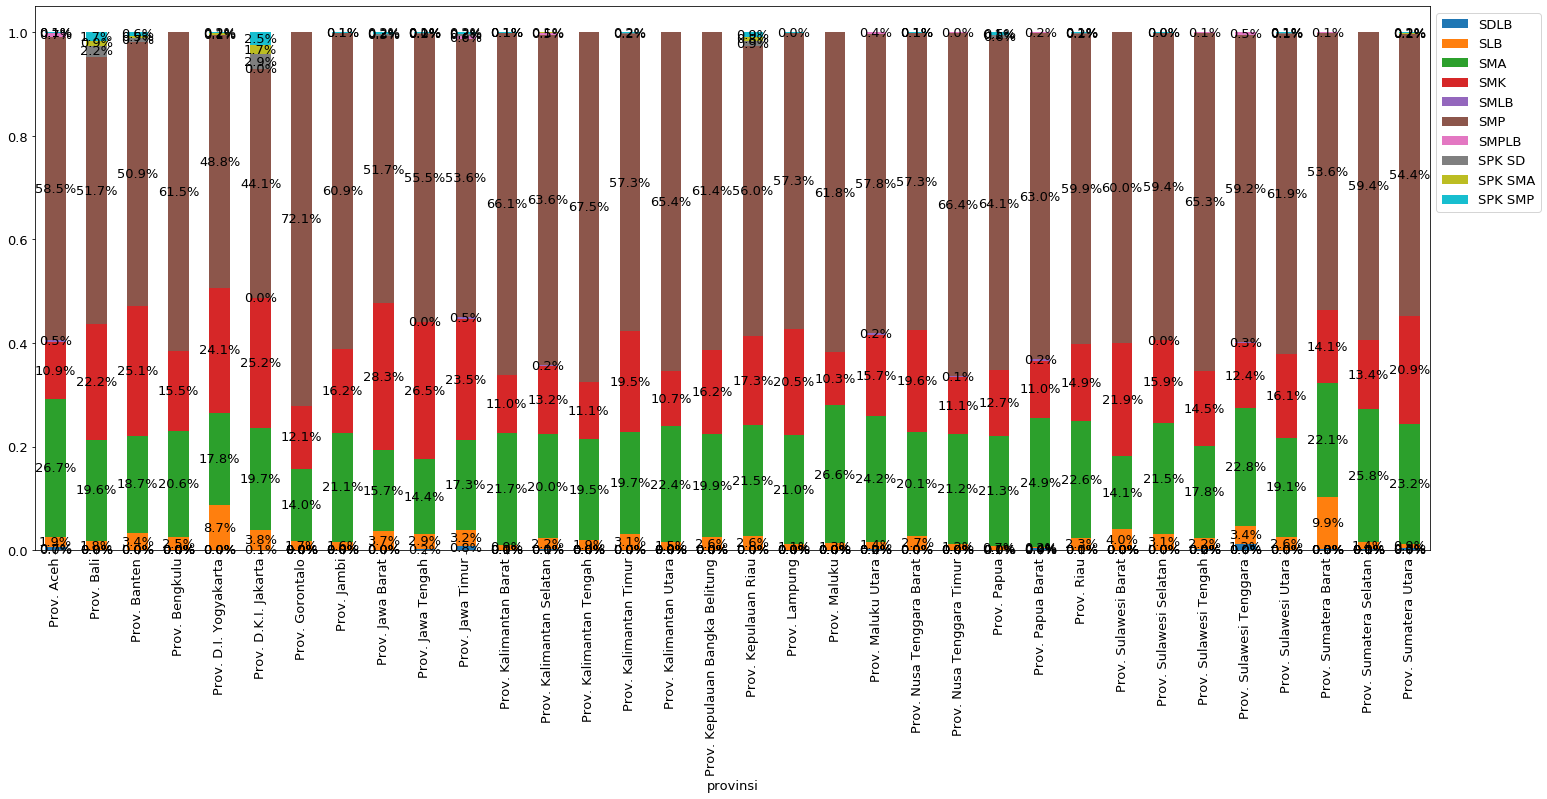

In [19]:
# dprov_bp_pct
ax=dprov_bp_pct.plot(kind='bar', stacked=True, figsize=(25,10))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.legend(bbox_to_anchor=(1, 1))


#### 4.School Numbers

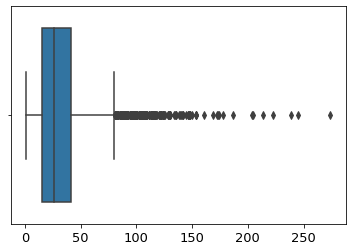

In [20]:
sns.boxplot(data_skul.groupby(['provinsi','kecamatan']).size())

In [21]:
df_kec_skul_cnt=data_skul.groupby(['provinsi','kecamatan']).size().reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

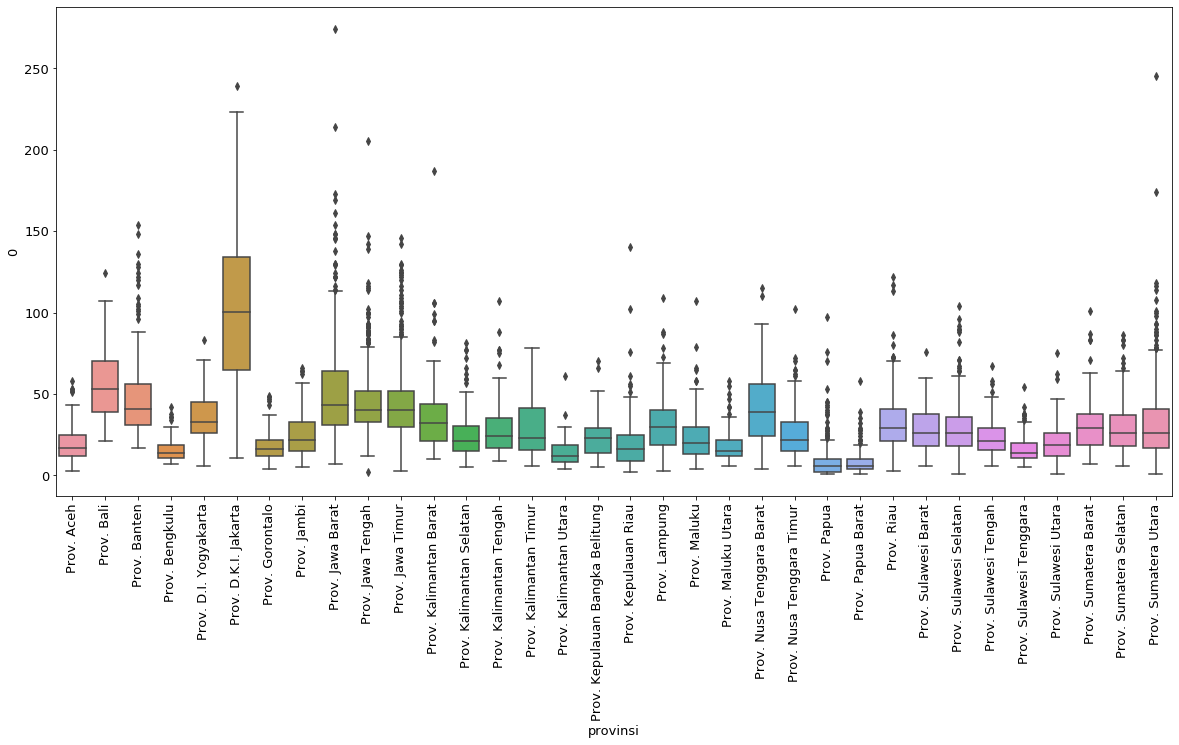

In [22]:
plt.figure(figsize=(20,9))
sns.boxplot(x='provinsi',y=0,data=df_kec_skul_cnt)
plt.xticks(rotation=90)

In [23]:
df_kec_skul_cnt[df_kec_skul_cnt[0]>200]

,provinsi,kecamatan,0
701,Prov. D.K.I. Jakarta,Kec. Cengkareng,239
706,Prov. D.K.I. Jakarta,Kec. Duren Sawit,204
712,Prov. D.K.I. Jakarta,Kec. Kali Deres,223
1060,Prov. Jawa Barat,Kec. Cibinong,274
1502,Prov. Jawa Barat,Kec. Tambun Selatan,214
1744,Prov. Jawa Tengah,Kec. Karanganyar,205
6750,Prov. Sumatera Utara,Kec. Percut Sei Tuan,245


## Simple Descriptive 

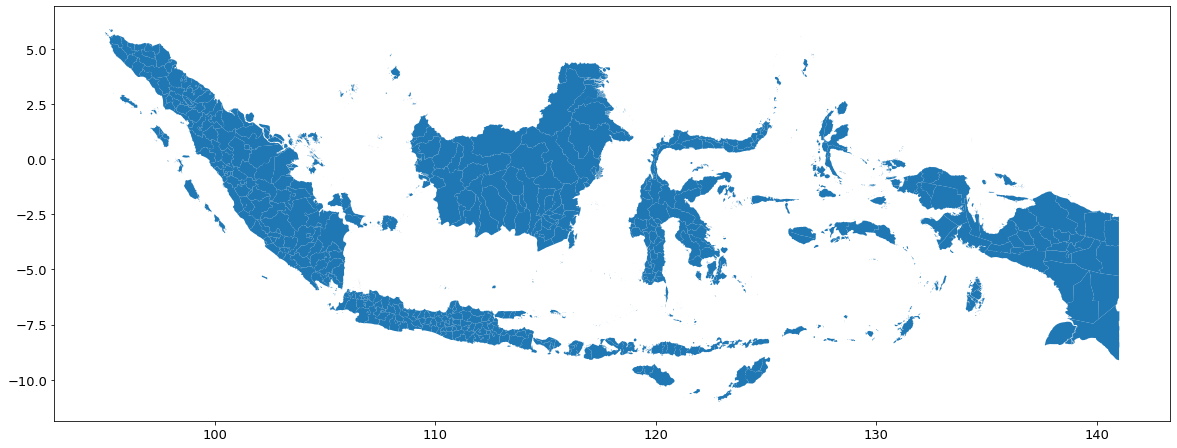

In [24]:
map_df.plot(figsize=(20,10))

#### Example Map Point

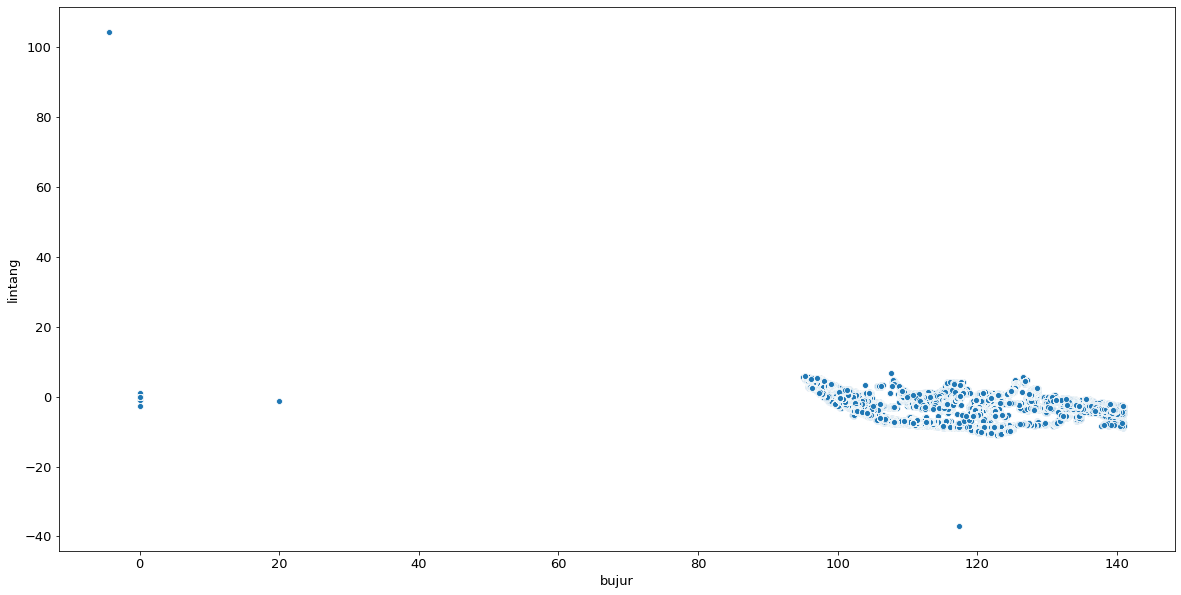

In [25]:
# data_interim2
plt.figure(figsize=(20,10))
sns.scatterplot(x='bujur',y='lintang',data=data_skul)

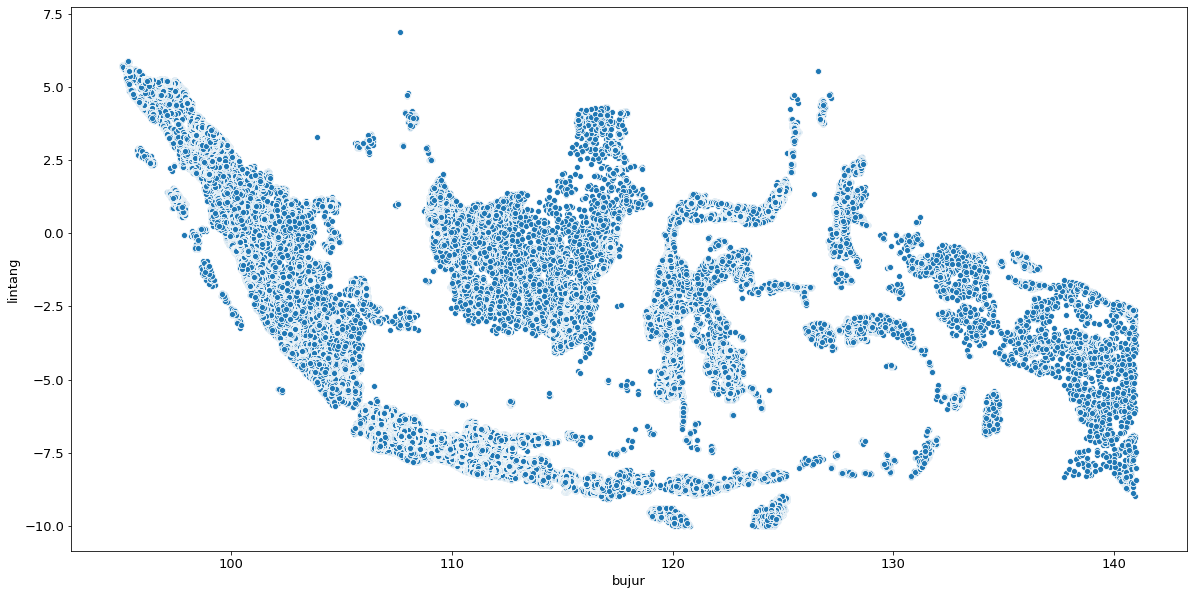

In [26]:
data_skul['outlier_point']=np.where((data_skul.lintang>20)|(data_skul.lintang<-10)|(data_skul.bujur<80),1,0)
# data_interim2
plt.figure(figsize=(20,10))
sns.scatterplot(x='bujur',y='lintang',data=data_skul[data_skul.outlier_point==0])

In [27]:
# len(data_skul.kab_kota.unique())

In [28]:
# map_reference
# map_df

In [29]:
data_merge_map=pd.merge(data_skul,map_reference[['kab_kota','NAME_2']],on='kab_kota',how='left')
data_merge_map=pd.merge(data_merge_map,map_df[['NAME_2','NAME_1']],on='NAME_2',how='left')

In [30]:
data_merge_map.bp.unique()

array(['SD', 'SMP', 'SMA', 'SMK', 'SDLB', 'SMPLB', 'SMLB', 'SLB',
       'SPK SD', 'SPK SMP', 'SPK SMA'], dtype=object)

In [31]:
# data_merge_map.bp.str.lower().str.contains

In [32]:
def get_school_map(prov_name):
    outlier=False
    split=True
    map_data=map_df.copy()
    source_data=data_merge_map.copy()
    
    if outlier:
        pass
    else:
        source_data=source_data[source_data['outlier_point']==0]
    
    data_point_example=source_data[source_data.NAME_1==prov_name]
    crs={'init':'epsg:4326'}
    
    fig,ax=plt.subplots(figsize=(12,12))
    map_data[map_data.NAME_1==prov_name].plot(ax=ax,alpha=0.4,color='grey')
    
    if split:
        for jenjang,lbl in zip(['sd','smp','sma'],[('red','SD'),('blue','SMP'),('black','SMA')]):
            data_point_jenjang=data_point_example[data_point_example.bp.str.lower().str.contains(jenjang)]
            geom=[Point(xy) for xy in zip(data_point_jenjang['bujur'],data_point_jenjang['lintang'])]
            geo_data_point=gpd.GeoDataFrame(data_point_jenjang,crs=crs,geometry=geom)
            geo_data_point.plot(ax=ax,markersize=20,color=lbl[0],label=lbl[1])
        
    else:
        geom=[Point(xy) for xy in zip(data_point_example['bujur'],data_point_example['lintang'])]
        geo_data_point=gpd.GeoDataFrame(data_point_example,crs=crs,geometry=geom)
        geo_data_point.plot(ax=ax,markersize=20,color='red',label='school')
    
    plt.legend(prop={'size':15})
    return plt.show()

In [33]:
map_df.NAME_1.unique()

array(['Aceh', 'Bali', 'Bangka Belitung', 'Banten', 'Bengkulu',
       'Gorontalo', 'Jakarta Raya', 'Jambi', 'Jawa Barat', 'Jawa Tengah',
       'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur', 'Kepulauan Riau',
       'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat',
       'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Riau',
       'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah',
       'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat',
       'Sumatera Selatan', 'Sumatera Utara', 'Yogyakarta'], dtype=object)

In [34]:
# # get_school_map('Yogyakarta',map_df,data_merge_map)
dropdown_province = widgets.Dropdown(options=map_df.NAME_1.unique())
interact(get_school_map,prov_name=dropdown_province);

interactive(children=(Dropdown(description='prov_name', options=('Aceh', 'Bali', 'Bangka Belitung', 'Banten', …

#### Example Radius

In [35]:
proj_wgs84 = pyproj.Proj(init='epsg:4326')


def geodesic_point_buffer(points, km):
    # Azimuthal equidistant projection
    x,y=points.coords[0]
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=x, lon=y)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]



def get_school_map_radius(kab_name,buff):
    outlier=False
    map_data=map_df.copy()
    source_data=data_merge_map.copy()
    
    if outlier:
        pass
    else:
        source_data=source_data[source_data['outlier_point']==0]
    
    data_point_example=source_data[source_data.NAME_2==kab_name]
#     crs={'init':'epsg:4326'}
    crs={'init': 'epsg:3174'}
    
    fig,ax=plt.subplots(figsize=(12,12))
    map_data[map_data.NAME_2==kab_name].plot(ax=ax,alpha=0.4,color='grey')

    geom=[Point(xy) for xy in zip(data_point_example['bujur'],data_point_example['lintang'])]
    pts=GeoSeries(geom)
    ## buff in KM
    circles = pts.buffer(buff)
    return circles.plot(ax=ax,alpha=0.4,color='black')

In [36]:
dropdown_kab = widgets.Dropdown(options=map_df.NAME_2.sort_values().unique())
interact(get_school_map_radius,kab_name=dropdown_kab,buff=[0.002,0.004,0.006,0.012]);

interactive(children=(Dropdown(description='kab_name', options=('Aceh Barat', 'Aceh Barat Daya', 'Aceh Besar',…

0.002 ~ 217 Meters
0.004 ~ 434 Meters
0.008 ~ 931 Meters
0.016 ~ 1829 Meters ~ 1.8 KM
0.026666 ~ 2.95 KM
0.0444444 ~ 4.92 KM
0.071111111 ~ 7.856 KM

In [37]:
# http://www.longitudestore.com/how-big-is-one-gps-degree.html
def deg_distance(deg):
    # 1 degree in equator
#     x=1*np.sin(deg)*111.32
#     y=1*np.cos(deg)*110.57
    
    # 1 minute in equator
    x=1*np.sin(deg)*1.84
    y=1*np.cos(deg)*1.86
    
    # 1 second in equator
#     x=1*np.sin(deg)*30.72
#     y=1*np.cos(deg)*30.92
    return np.sqrt((x**2)+(y**2))

def dec_to_dms(buff):
    Deg=np.floor(buff)
    buff0=buff-Deg
    base_min=(1/60)
    Minu=0
    while buff0>base_min:
        buff0=buff0-base_min
        Minu+=1
    Sec=buff0*3600
    return Deg,Minu,Sec

def radius_to_km(buff):
    x,y,z=dec_to_dms(buff)
    distance=(x*110.93899)+(y*1.85018)+(z*0.030821)
    return distance

In [38]:
radius_to_km(0.002)

0.2219112

#### Example of heatmap

In [39]:
# map_df

In [40]:
school_cnt=data_merge_map[data_merge_map.outlier_point==0].groupby(['NAME_2']).size().reset_index()
school_cnt_map=pd.merge(map_df,school_cnt,how='left',on='NAME_2')

In [49]:
school_cnt_map[school_cnt_map[0].isnull()==True]

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,0
59,IDN,Indonesia,IDN.6_1,Gorontalo,None,IDN.6.3_1,Danau Limboto,None,None,Kabupaten,Regency,7502,ID.GO.GO,"POLYGON ((123.01784515 0.56959265, 123.0177536...",NaN
107,IDN,Indonesia,IDN.9_1,Jawa Barat,None,IDN.9.27_1,Waduk Cirata,None,None,Water Body,Water Body,3288,None,"POLYGON ((107.28666687 -6.78579998, 107.286529...",NaN
141,IDN,Indonesia,IDN.10_1,Jawa Tengah,None,IDN.10.34_1,Waduk Kedungombo,None,None,Water Body,Water Body,3388,None,"(POLYGON ((110.83525848 -7.30740309, 110.83543...",NaN
190,IDN,Indonesia,IDN.12_1,Kalimantan Barat,None,IDN.12.9_1,Pontianak,None,None,Kabupaten,Regency,6104,ID.KB.PR,"(POLYGON ((108.85961151 0.51084, 108.85968781 ...",NaN
292,IDN,Indonesia,IDN.21_1,Nusa Tenggara Timur,None,IDN.21.5_1,Kota Kupang,None,None,Kota,City,5371,ID.NT.KM,"POLYGON ((123.58547974 -10.28884983, 123.58477...",NaN
300,IDN,Indonesia,IDN.21_1,Nusa Tenggara Timur,None,IDN.21.13_1,Rote Ndao,None,None,Kabupaten,Regency,5314,ID.NT.RN,"(POLYGON ((122.87141418 -10.96884727, 122.8731...",NaN
301,IDN,Indonesia,IDN.21_1,Nusa Tenggara Timur,None,IDN.21.14_1,Sabu Raijua,None,None,Kabupaten,Regency,5320,ID.NT.SJ,"(POLYGON ((121.27793121 -10.82205391, 121.2793...",NaN
364,IDN,Indonesia,IDN.25_1,Sulawesi Barat,None,IDN.25.3_1,Mamuju Utara,None,None,Kabupaten,Regency,7605,ID.SR.MU,"POLYGON ((119.34526062 -1.79376125, 119.345153...",NaN
394,IDN,Indonesia,IDN.27_1,Sulawesi Tengah,None,IDN.27.5_1,Morowali,None,None,Kabupaten,Regency,7203,ID.ST.MO,"(POLYGON ((123.04191589 -3.54919505, 123.04098...",NaN
403,IDN,Indonesia,IDN.28_1,Sulawesi Tenggara,None,IDN.28.4_1,Buton,None,None,Kabupaten,Regency,7401,ID.SG.BN,"(POLYGON ((122.73675537 -6.21320581, 122.73654...",NaN


In [52]:
school_cnt_map2=school_cnt_map[school_cnt_map[0].isnull()==False]

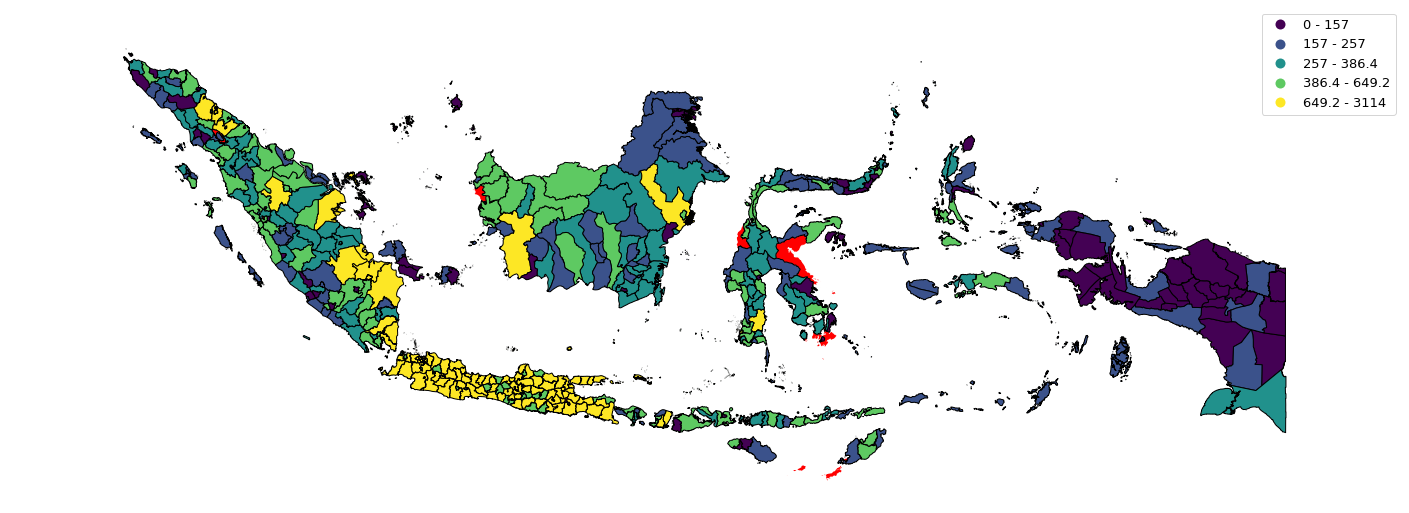

In [56]:
ax=geoplot.choropleth(
    school_cnt_map2, hue=school_cnt_map2[0], figsize=(25,15), legend=True
)

school_cnt_map[school_cnt_map[0].isnull()==True].plot(ax=ax, color='red')